In [1]:
import pandas as pd
import numpy as np
import yaml
import datetime
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
import math

from tqdm import tqdm

from config import RANKER, POINTWISE_EPSILON, POINTWISE_C, POINTWISE_KERNEL, PAIRWISE_BATCH_SIZE, PAIRWISE_EPOCHS
from ranker.pairwise import ComparisonCreator, RankNet
from ranker.pointwise import SupportVectorRegression, PointwiseNN


def visualize_model(model_name:str, data):
    data['index'] = data.index
    data = data.melt('index')
    ax = sns.lineplot(x='index', y="value", hue="variable", data=data)
    plt.show()


if __name__ == '__main__':

    #np.random.seed(seed=21203)

    df = pd.read_csv('./resources/flughafen/data.csv', sep=";")
    config = yaml.load(open('./resources/flughafen/config.yml'))
    time_regex = config['config']['timestamp_regex']
    df['timestamp'] = df['timestamp'].apply(lambda x: datetime.datetime.strptime(x, time_regex))

    x = df.drop('value',axis =1)
    y = df['value']
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=1)

    # create a 2d array to save y
    y_array = np.array(y_test, ndmin=2)
    for i in range(999):
        y_array = np.concatenate([np.array(y_test, ndmin=2), y_array])

    # initialize a 2d array to save y^
    initializer = np.random.normal(100, 1, 6790)
    prediction_array = np.array(initializer, ndmin=2)

    # Select the sigma randomly in the range of (std*0.75, std*1.25)
    std = np.sqrt(np.var(y_train))
    sigma = np.random.uniform(std * 0.9, std * 1.1, 1000).tolist()

    model = []
    y = []
    MSE_model = []
    R2_model = []
    RMSE_model = []
    counter = 1

    # iterate mu and sigma 1000 times to simulate 1000 models and calculate the mse
    for mu, sigma in zip(y_test, sigma):
        prediction = np.random.normal(mu, sigma, 6790)
        # save mse
        mse = mean_squared_error(y_test, prediction)
        MSE_model.append(mse)
        #save r2
        r2 = r2_score(y_test, prediction)
        R2_model.append(r2)
        # save rmse
        rmse =np.sqrt(mse)
        RMSE_model.append(rmse)

        prediction = np.array(prediction, ndmin=2)
        # save y^ to a 2d array
        prediction_array = np.concatenate([prediction_array, prediction])
        # save model name
        model.append('Model-%d' % (counter))
        counter = counter + 1

    # delete the initializer
    prediction_array = prediction_array[1:]


    # Create dataset for the ranker based on the MSE preference
    MSE_2d = np.array([1], ndmin=2)
    for i in MSE_model:
        MSE_2d_element = np.array(i, ndmin=2)
        MSE_2d = np.concatenate([MSE_2d, MSE_2d_element])

    MSE_2d = MSE_2d[1:]

    models = {'model': model, 'y': y_array, 'y^': prediction_array, 'MSE': MSE_model, 'R2':R2_model, 'RMSE': RMSE_model}

    # CREATE RANKER DATASET

    # merge y_ground truth and prediction y for X dataset (ranker)
    X = np.concatenate((y_array, prediction_array), axis=1)
    #X = prediction_array
    y = MSE_2d
    #scale X
    scaler_X = MinMaxScaler()
    X = scaler_X.fit_transform(X=X, y=y)
    #scale y
    scaler_y = MinMaxScaler()
    #y = scaler_y.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    ranker_r2 = []
    ranker_mse = []
    ranker_rmse = []
    ranker_top_k_accs = []


    data_count = [1,5,10,100,200,300,400,500,600,700,800,900,1000,2000]
    top_k = [1,5,10,50,100]
    for i in tqdm(data_count):
        # Choose ranking model
        if RANKER == 1:
            model = SupportVectorRegression(epsilon=POINTWISE_EPSILON,C=POINTWISE_C,kernel=POINTWISE_KERNEL)
            print('Train the pointwise Ranker')
        elif RANKER == 2:
            model = PointwiseNN()
            print('Train the Paarwise Ranker')
        elif RANKER == 3:
            model = RankNet(batch_size=PAIRWISE_BATCH_SIZE, epochs=PAIRWISE_EPOCHS, number_comparisons=i)

        # train ranking model
        model.fit(X_train=X_train[:i], y_train=y_train[:i])

        #predict ranking model
        y_pred = model.predict(X=X_test)

        order_y_test = np.argsort(y_test,axis=0)[::-1]
        order_y_pred = np.argsort(y_pred, axis=0)[::-1]
        order_y_test_norm = np.argsort(y_test,axis=0)[::-1]/200
        order_y_pred_norm = np.argsort(y_pred, axis=0)[::-1]/200
        acc_top_k = []
        
        # Check the rate that the top k elements are correctly ranked.
        for k in top_k:
            top_k_index_test_set = []
            true_top_k = 0  
            # Find the index of top k elements in the test array.
            for i in list(order_y_test):
                if int(i) <=k: 
                    top_k_index_test_set.append(list(order_y_test).index(i))  

            for o in list(order_y_pred):
                # if o are in top k
                if int(o) <= k:
                    # check if the index of o is in the index array of top k elements in test set
                    # if true, if s correctly ranked
                    if list(order_y_pred).index(o) in top_k_index_test_set:
                        true_top_k += 1
            acc = float(true_top_k) / float(k)
            acc_top_k.append(acc)
        
        #append results
        ranker_top_k_accs.append(acc_top_k)
        ranker_r2.append(r2_score(y_true=y_test,y_pred=y_pred))
        ranker_mse.append(mean_squared_error(y_true=order_y_test_norm,y_pred=order_y_pred_norm))
        ranker_rmse.append(math.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
      
            
   
        
        

    results= {'data_count':data_count,
              'r2':ranker_r2,
              'mse':ranker_mse,
              'rmse':ranker_rmse,
              }
    #append top k
    for tk, val in enumerate(top_k):
        results['acc_top_'+str(val)] = [i[tk] for i in ranker_top_k_accs]

    


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  0%|          | 0/14 [00:00<?, ?it/s]

Train the Paarwise Ranker
Train on 1 samples
1/1 [==============================] - 1s 793ms/sample - loss: 1907169951744.0000


  7%|▋         | 1/14 [00:01<00:17,  1.33s/it]

Train the Paarwise Ranker
Train on 5 samples
5/5 [==============================] - 1s 104ms/sample - loss: 1907548749824.0000


 14%|█▍        | 2/14 [00:02<00:14,  1.24s/it]

Train the Paarwise Ranker
Train on 10 samples
10/10 [==============================] - 1s 52ms/sample - loss: 1829495373824.0000


 21%|██▏       | 3/14 [00:03<00:12,  1.14s/it]

Train the Paarwise Ranker
Train on 100 samples
100/100 [==============================] - 1s 6ms/sample - loss: 3565037299957.7603


 29%|██▊       | 4/14 [00:04<00:10,  1.10s/it]

Train the Paarwise Ranker
Train on 200 samples
200/200 [==============================] - 1s 5ms/sample - loss: 4032727749754.8799


 36%|███▌      | 5/14 [00:05<00:10,  1.16s/it]

Train the Paarwise Ranker
Train on 300 samples
300/300 [==============================] - 1s 3ms/sample - loss: 3976177434405.5464


 43%|████▎     | 6/14 [00:06<00:09,  1.18s/it]

Train the Paarwise Ranker
Train on 400 samples
400/400 [==============================] - 1s 2ms/sample - loss: 4020286500372.4800


 50%|█████     | 7/14 [00:08<00:08,  1.26s/it]

Train the Paarwise Ranker
Train on 500 samples
500/500 [==============================] - 1s 2ms/sample - loss: 4026923371986.9443


 57%|█████▋    | 8/14 [00:09<00:07,  1.32s/it]

Train the Paarwise Ranker
Train on 600 samples
600/600 [==============================] - 1s 2ms/sample - loss: 4135332414313.8135


 64%|██████▍   | 9/14 [00:11<00:06,  1.38s/it]

Train the Paarwise Ranker
Train on 700 samples
700/700 [==============================] - 1s 2ms/sample - loss: 4187190499363.1084


 71%|███████▏  | 10/14 [00:13<00:06,  1.52s/it]

Train the Paarwise Ranker
Train on 800 samples
800/800 [==============================] - 1s 2ms/sample - loss: 4167300085186.5601


 79%|███████▊  | 11/14 [00:14<00:04,  1.55s/it]

Train the Paarwise Ranker
Train on 800 samples
800/800 [==============================] - 1s 2ms/sample - loss: 4167540041318.4004


 86%|████████▌ | 12/14 [00:16<00:03,  1.61s/it]

Train the Paarwise Ranker
Train on 800 samples
800/800 [==============================] - 1s 2ms/sample - loss: 4167237946572.7998


 93%|█████████▎| 13/14 [00:18<00:01,  1.62s/it]

Train the Paarwise Ranker
Train on 800 samples
800/800 [==============================] - 1s 2ms/sample - loss: 4167494333890.5601


100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


In [2]:
len(x_train)

27159

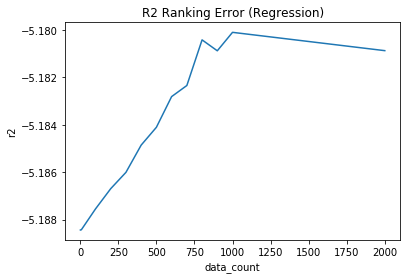

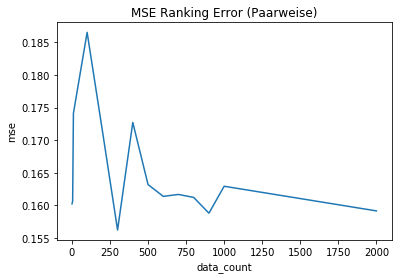

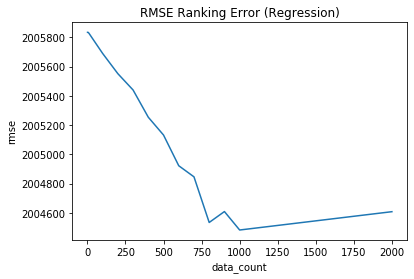

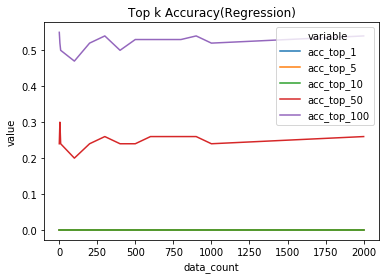

In [5]:
results = pd.DataFrame(data=results)
results['index'] = results.index
ax_1 = sns.lineplot(x='data_count', y="r2", data=results)
plt.title('R2 Ranking Error (Regression)')
plt.show()
ax_2 = sns.lineplot(x='data_count', y='mse', data=results)
plt.title('MSE Ranking Error (Paarweise)')
plt.show()
ax_3 = sns.lineplot(x='data_count', y='rmse', data=results)
plt.title('RMSE Ranking Error (Regression)')
plt.show()
#plot_top_k
results_top_k = {'data_count': data_count}
for tk, val in enumerate(top_k):
    results_top_k['acc_top_' + str(val)] = [i[tk] for i in ranker_top_k_accs]
results_top_k = pd.DataFrame(results_top_k)

sns.lineplot(x='data_count', y='value', hue='variable',
                data=pd.melt(results_top_k, ['data_count']))
plt.title('Top k Accuracy(Regression)')
plt.show()

In [4]:
# Check the rate that the top k elements are correctly ranked.
        for k in top_k:
            top_k_index_test_set = []
            true_top_k = 0  
            # Find the index of top k elements in the test array.
            for i in list(order_y_test):
                if int(i) <=k: 
                    top_k_index_test_set.append(list(order_y_test).index(i))  

            for o in list(order_y_pred):
                # if o are in top k
                if int(o) <= k:
                    # check if the index of o is in the index array of top k elements in test set
                    # if true, if s correctly ranked
                    if list(order_y_pred).index(o) in top_k_index_test_set:
                        true_top_k += 1
            acc = float(true_top_k) / float(k)
            acc_top_k.append(acc)

IndentationError: unexpected indent (<ipython-input-4-99d22539f05c>, line 2)

In [ ]:
for k in top_k:
            true_top_k = 0
            # for loop for all top_k
            for o in list(order_y_pred)[:k]:
                if int(o) in order_y_test[:k]:
                    true_top_k += 1
            acc = float(true_top_k) / float(k)
            acc_top_k.append(acc)